In [239]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [241]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [242]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [243]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [244]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [245]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [246]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [247]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

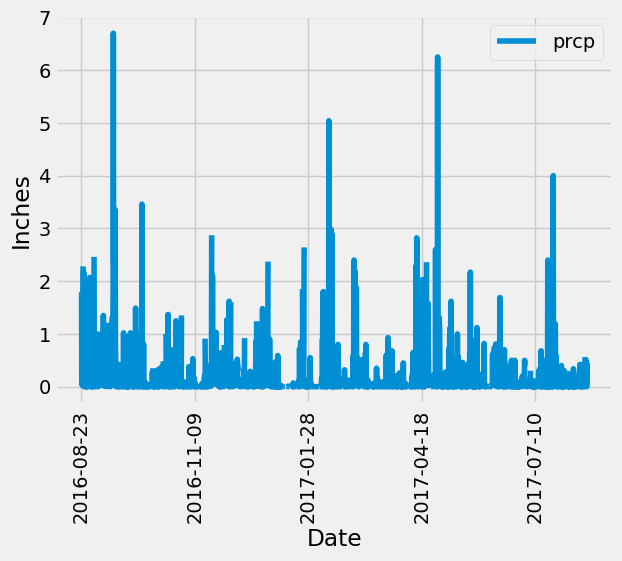

In [248]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_str = recent_date[0]
date_obj = dt.datetime.strptime(recent_date_str, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
twelve_months_ago = date_obj - dt.timedelta(days=365)
start_date = twelve_months_ago.strftime('%Y-%m-%d')
end_date = recent_date_str

# Perform a query to retrieve the data and precipitation scores
query = """ SELECT date, prcp FROM measurement WHERE date >= '2016-08-23' """

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query, engine)

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df['prcp'].plot(kind='line', xlabel='Date', ylabel='Inches', legend=True);

plt.xticks(rotation=90);

In [249]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df['prcp'].describe()
pd.DataFrame(summary)

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [250]:
measurement.__dict__

mappingproxy({'__table__': Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 18f85f9ed50>,
              '__init__': <function sqlalchemy.orm.instrumentation.__init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x18f949f28e0>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x18f949f2980>,
              'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x18f949f27a0>,
              'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x18f949f2a20>,
       

In [251]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.id)).scalar()

9

In [252]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(
    measurement.station, func.count(measurement.station).label('row_count')
    ).group_by(measurement.station).order_by(func.count(measurement.station).desc())
most_active.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [253]:
query = "SELECT date, tobs FROM measurement WHERE date >= '2016-08-23'"

tobs = pd.read_sql(query, engine)
tobs.sort_values(by='date', inplace=True)
tobs.head()

,date,tobs
0,2016-08-23,81.0
1009,2016-08-23,80.0
1529,2016-08-23,77.0
704,2016-08-23,80.0
361,2016-08-23,76.0


In [254]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs).filter(measurement.station == most_active[0][0]),
                      func.max(measurement.tobs).filter(measurement.station == most_active[0][0]),
                      func.avg(measurement.tobs).filter(measurement.station == most_active[0][0]))
temps.all()

[(54.0, 85.0, 71.66378066378067)]

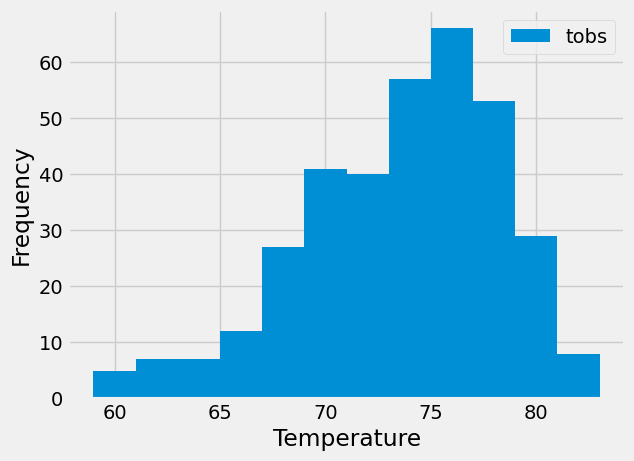

In [255]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = "SELECT station, date, tobs FROM measurement WHERE date >= '2016-08-23' AND station == 'USC00519281'"
temp_obs = pd.read_sql(query, engine)
temp_obs.sort_values(by='date', inplace=True)
temp_obs.plot(kind='hist', bins=12, xlabel='Temperature');

# Close Session

In [256]:
# Close Session
session.close()